## 4. ベースラインモデルの構築と評価

**概要:**
- 本ノートブックでは、Holt-Winters法とSARIMAXモデルを用いて発電量・消費量の予測を行い、ベースライン性能を評価する。

### 4-1. 準備：ライブラリ、データ、評価手法の定義

### 4-2-1. 評価指標と検証手法
予測精度評価には、MAE、RMSE、およびスケールに依存しないMASE（Mean Absolute Scaled Error）を用いる。MASEの計算では、発電量は日周期（m=48）、消費量は週周期（m=336）を季節ナイーブ予測の基準とした。

モデル評価の頑健性を高めるため、学習区間と予測区間をスライドさせながら予測と評価を繰り返す、時系列交差検証（スライディングウィンドウ法）を採用する。

### 4-2-2. スライディングウィンドウ関数の定義と予測期間の設定

#### Sliding Window 関数の定義
時系列交差検証のため、学習区間と予測区間を一定の幅でスライドさせながら予測と評価を繰り返す `sliding_window_forecast` 関数を定義した。

#### 4-1-1. ライブラリのインポートとデータ読み込み

In [1]:
# ライブラリのインポート
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from tqdm.notebook import tqdm
import itertools
import warnings

# 時系列モデル関連
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import jarque_bera
import statsmodels.api as sm
import pmdarima as pm

# 共通モジュールのインポート
from src.data_utils import load_timeseries_data
from src.evaluation_utils import evaluate_forecast
from src.forecast_utils import sliding_window_forecast
from src.plot_utils import plot_forecast_vs_actual

# スタイル設定
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams['font.family'] = 'Meiryo' # Windowsの場合。Macの場合は 'Hiragino Sans' など

# 警告を非表示
warnings.filterwarnings('ignore')

In [2]:
# load data
BASE_DIR = Path().resolve()
DATA_DIR = BASE_DIR.parent / "data"
target_file = DATA_DIR / "e_gen_demand.csv"

df = load_timeseries_data(target_file)

print("データ形状:", df.shape)
print("データ期間:", df.index.min(), "から", df.index.max())
df.head()

データ形状: (39408, 2)
データ期間: 2023-01-01 00:00:00 から 2025-03-31 23:30:00


,solar_gen_mw,e_demand_mw
datetime,,
2023-01-01 00:00:00,0,29870
2023-01-01 00:30:00,0,28640
2023-01-01 01:00:00,0,27560
2023-01-01 01:30:00,0,27240
2023-01-01 02:00:00,0,26650


In [3]:
# 07_lightGBM.ipynb, 08_gru_forecast.ipynb の　yをshiftさせる手法との関係で
# 1日データを後ろに移行する
df = df[48:]
df.head()

,solar_gen_mw,e_demand_mw
datetime,,
2023-01-02 00:00:00,0,26500
2023-01-02 00:30:00,0,25590
2023-01-02 01:00:00,0,24850
2023-01-02 01:30:00,0,24460
2023-01-02 02:00:00,0,24430


#### 4-1-2. 評価指標と検証手法の定義

### 4-2-1. 評価指標と検証手法

- モデル評価の頑健性を高めるため、学習区間と予測区間をスライドさせながら予測と評価を繰り返す、時系列交差検証（スライディングウィンドウ法）を採用する。

**sliding_window 法を実行する関数**
`src/forecast_utils.py` 内 `sliding_window_forecast`
- 引数に　DataFrame, 予測対象列, 学習区間の長さ, スライド回数, スライド幅, model_func, model_paramsを取り、model_funcには　train_series, test_steps, **params　とパラメーターを受け取ることができる。
- 説明変数列はないが、SARIMAX　などでは　exog として外生変数も使用できる。
- model_func　の返り値は　preds, model, insample でpreds以外が欠けても良い。

- 予測精度評価には、MAE、RMSE、およびスケールに依存しないMASE（Mean Absolute Scaled Error）を用いる。MASEの計算では、発電量は日周期（m=48）、消費量は週周期（m=336）を季節ナイーブ予測の基準とした。

**評価関数** 
`src/evaluation_utils.py` 内 `evaluate_forecast`
- `mean_absolute_scaled_error` 関数で周期を指定したMASEを計算、y_true, y_preds から　MAE, RMSE, MASEを計算しdictで返す。
- MASEの分母は　y_train のMAEであることに注意。そのため引数に y_train も取り、テスト区間に対してナイーブ予想を行っても常に1とはならない。

#### 4-1-3. 予測期間の共通設定

以降のモデル評価は、計算負荷と実用性を考慮し、以下の共通パラメータで実施する。

| パラメータ名 | 値 | 意味 |
| :--- | :--- | :--- |
| **学習期間** (`TRAIN_LENGTH`) | 2880ステップ | 60日分 ($60 \times 48$) |
| **テスト期間** (`TEST_LENGTH`) | 48ステップ | 1日分 ($1 \times 48$) |
| **スライド回数** (`SLIDE_COUNT`) | 30回 | 30日分のテストデータを生成 |
| **スライド幅** (`STRIDE`) | 48ステップ | 1日ずつ（非重複）スライド |

In [4]:
# スライディングウィンドウの共通パラメータ
TRAIN_LENGTH = 2880  # 60 days * 48 points/day
TEST_LENGTH = 48     # 1 day * 48 points/day
SLIDE_COUNT = 30     # 30 days
STRIDE = 48          # 1 day (non-overlapping)

### 4-2. Holt-Wintersモデルによる予測

#### 4-2-1. モデルの定義と予測実行

In [5]:
# Holt-Wintersモデルのラッパー関数
def holt_winters_model_wrapper(train_data, test_steps, **kwargs):
    '''Holt-Wintersモデルを学習・予測し、モデルオブジェクトも返すラッパー関数'''    
    fit = ExponentialSmoothing(
        train_data,
        seasonal_periods=kwargs.get("seasonal_periods", 48),
        trend=kwargs.get("trend", "add"),
        seasonal=kwargs.get("seasonal", "add"),
        damped_trend=kwargs.get("damped_trend", False),
        initialization_method="estimated",
        use_boxcox=kwargs.get("use_boxcox", False),
    ).fit()
    # 予測、モデル、In-sample予測のタプルを返す
    return fit.forecast(test_steps), fit, None

# --- 発電量の予測 ---
print("Holt-Winters: 発電量の予測を開始...")
hw_gen_preds_df, _, _ = sliding_window_forecast(
    data=df,
    y_col='solar_gen_mw',
    train_length=TRAIN_LENGTH,
    test_length=TEST_LENGTH,
    slide_count=SLIDE_COUNT,
    stride=STRIDE,
    model_func=holt_winters_model_wrapper,
    model_params={
        "seasonal_periods": 48,
        "seasonal": "add",
        "damped_trend": True,
        "use_boxcox": False,
    }    
    )
print("完了。")

# 評価 (MASEの季節周期m=48)
y_train_gen = df['solar_gen_mw'].iloc[:TRAIN_LENGTH]
hw_gen_metrics = evaluate_forecast(hw_gen_preds_df['true'], hw_gen_preds_df['pred'], y_train_gen.values, m=48)

# --- 消費量の予測 ---
print("Holt-Winters: 消費量の予測を開始...")
hw_con_preds_df, _, _ = sliding_window_forecast(
    data=df,
    y_col='e_demand_mw',
    train_length=TRAIN_LENGTH,
    test_length=TEST_LENGTH,
    slide_count=SLIDE_COUNT,
    stride=STRIDE,
    model_func=holt_winters_model_wrapper,
    model_params={
        "seasonal_periods": 336,
        "seasonal": "mul",
        "damped_trend": True,
        "use_boxcox": 0.0,
    }
    )
print("完了。")

# 評価 (MASEの季節周期m=336)
y_train_con = df['e_demand_mw'].iloc[:TRAIN_LENGTH]
hw_con_metrics = evaluate_forecast(hw_con_preds_df['true'], hw_con_preds_df['pred'], y_train_con.values, m=336)

# --- 評価結果の集計 ---
hw_summary = pd.DataFrame({
    'generation': hw_gen_metrics,
    'consumption': hw_con_metrics
})

print("--- Holt-Winters 評価結果 (30日間) ---")
print(hw_summary)

Holt-Winters: 発電量の予測を開始...


Sliding Window:   0%|          | 0/30 [00:00<?, ?it/s]

完了。
Holt-Winters: 消費量の予測を開始...


Sliding Window:   0%|          | 0/30 [00:00<?, ?it/s]

完了。
--- Holt-Winters 評価結果 (30日間) ---
       generation  consumption
MAE   1663.867984  1663.890819
RMSE  2740.709025  2212.888753
MASE     2.261408     0.526893


#### 4-2-2. 予測結果の可視化と評価


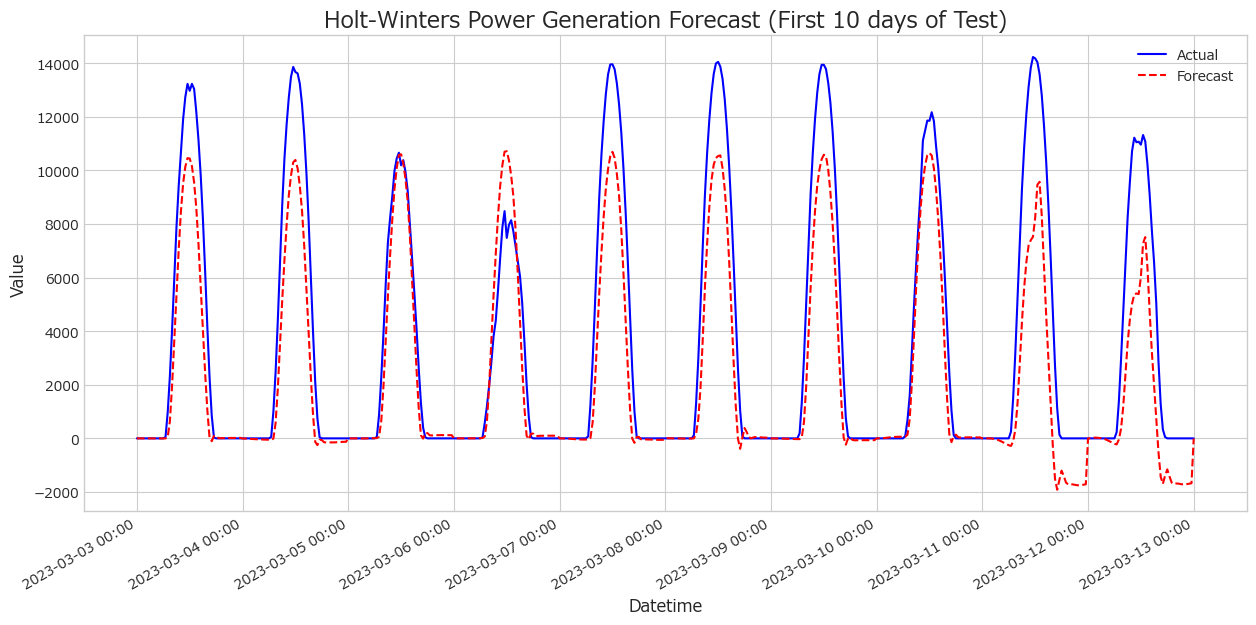

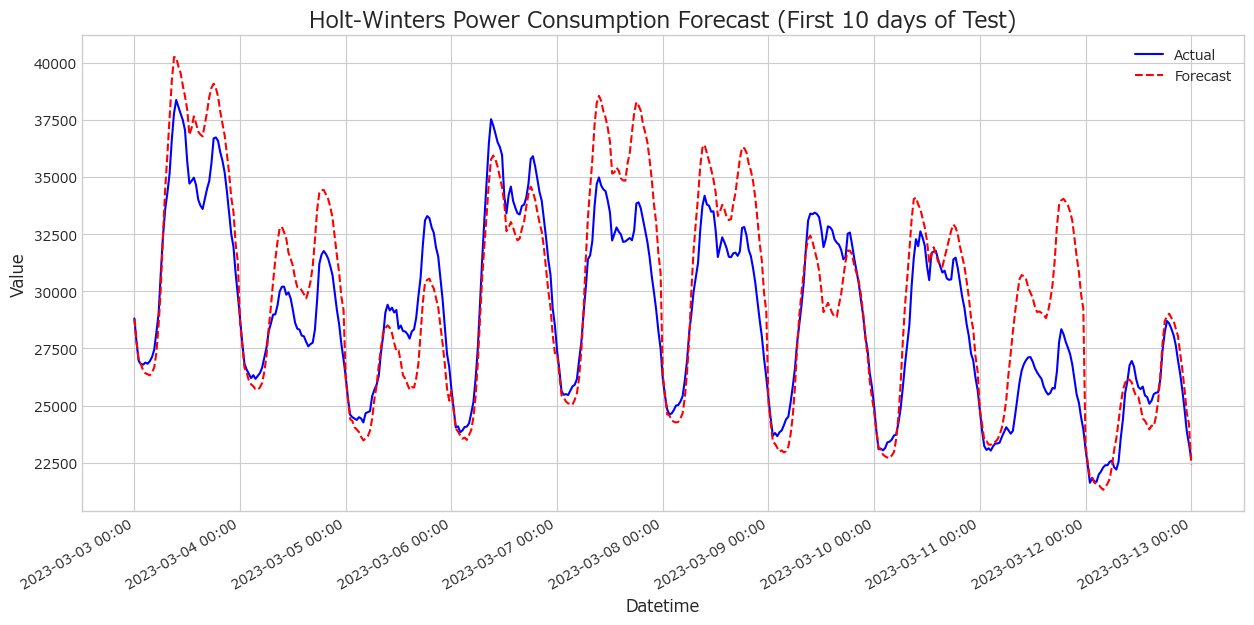

In [6]:
# Holt-Wintersの結果をプロット
#  発電
plot_forecast_vs_actual(
    hw_gen_preds_df, 
    title='Holt-Winters Power Generation Forecast (First 10 days of Test)', 
    days_to_show=10
)
# 消費
plot_forecast_vs_actual(
    hw_con_preds_df, 
    title='Holt-Winters Power Consumption Forecast (First 10 days of Test)', 
    days_to_show=10
)

In [7]:
# 結果の保存
# pred_df には 'true', 'pred' カラムと datetime index がある前提

# solar_gen_mw
hw_gen_preds_df.to_pickle('../results/preds/solar_hw.pkl')
print("Saved: ")

# e_demand_mw
hw_con_preds_df.to_pickle('../results/preds/demand_hw.pkl')
print("Saved: ")

Saved: 
Saved: 


#### 4-2-3. 考察

**精度評価**

| 指標 | generation (発電量) | consumption (消費量) |
| :--- | :--- | :--- |
| **MAE** | 1663.8 | 1663.890819 |
| **RMSE** | 2740.71 | 2212.89 |
| **MASE** | **2.261** | **0.527** |

Holt-Winters法は、トレンドと季節性を捉えるための比較的シンプルなモデルである。今回のタスクにおける評価は以下の通りである。

- 発電量予測: 予測値はMASEが2.26と振るわず、実際の変動を捉えきれておらず、特にピーク時の誤差が大きい。これは、発電量が天候などの不規則な要因に大きく影響されるため、単純な季節性パターンだけでは表現が困難であることを示唆している。
- 消費量予測: 発電量に比べ、予測値は実際の値の推移を比較的よく追従している。MASE指標においても0.53と比較的良好な値を示しており、消費量の変動が持つ強い季節性パターンをモデルが捉えられていることがわかる。
- 次工程への示唆: Holt-Winters法は計算負荷が軽く、少ないパラメータで迅速にベースラインを構築できる点で有用である。消費量予測においては一定の成果が得られたが、発電量予測の精度向上には、より複雑な変動要因をモデルに組み込む必要がある。

### 4-3. SARIMAXモデルによる予測

#### 4-3-1. パラメータ探索（auto_arima）

## 4-4. SARIMAXモデルによる予測

**パラメータの検討**

#### 計算負荷軽減のためのフーリエ項導入
* SARIMAモデルは季節周期 $S$ が長い場合（例: 週周期 $S=336$）、モデル学習の計算コストが非常に高くなる。この問題を回避し、効率的に複雑な季節性を表現するため、**フーリエ項（三角関数）を外部変数** (`exog`) としてモデルに組み込むアプローチを採用する。

* フーリエ項は周期的な変動を担うことで、SARIMAXモデル自体の季節項 (`seasonal_order=(P, D, Q, S)`) を `(0, 0, 0, 0)` に設定することが可能となり、パラメータ探索と学習の計算時間を大幅に短縮し、計算の収束性も向上させる。

**発電量 (`solar_gen_mw`) のパラメータ探索**

発電量は**日周期**（$S=48$）の変動が主であるため、これに対応するフーリエ項を生成し、最適な非季節次数 $(p, d, q)$ をグリッドサーチで探索した。

* **フーリエ項**: $S=48$（日周期）、ペア数 $K=5$
* **探索範囲**: $p \in [0, 3], d \in [0, 1], q \in [0, 3]$

In [8]:
# solar_gen_mw 用（周期 S=48 をフーリエ項で表現）

# データ抽出（最初の30日分）
y_gen_search = df['solar_gen_mw'].iloc[30*48:60*48] # 1月1日からやや特異日（特に消費で）なのでずらす

# --- フーリエ項の生成 (S=48) ---
time_steps_gen = np.arange(len(y_gen_search))
K_gen = 5 # フーリエ項のペア数
fourier_terms_gen = pd.DataFrame(index=y_gen_search.index)
S_gen = 48

for i in range(1, K_gen + 1):
    sin_term = np.sin(2 * np.pi * i * time_steps_gen / S_gen)
    cos_term = np.cos(2 * np.pi * i * time_steps_gen / S_gen)
    fourier_terms_gen[f'sin_{S_gen}_{i}'] = sin_term
    fourier_terms_gen[f'cos_{S_gen}_{i}'] = cos_term

# --- パラメータ探索 ---
p = range(0, 4)
d = range(0, 2)       
q = range(0, 4)

order_list = list(itertools.product(p, d, q))

results_gen = []
print(f"グリッドサーチを開始します (solar_gen_mw with Fourier terms)。試行回数: {len(order_list)}回")

for order in tqdm(order_list, desc="ARIMAX Search (Gen)"):
    try:
        model = SARIMAX(y_gen_search,
                        exog=fourier_terms_gen,
                        order=order,
                        seasonal_order=(0, 0, 0, 0), # 季節性はexogが担当
                        trend='c',
                        enforce_stationarity=False,
                        enforce_invertibility=False,
                        simple_differencing=False
                       ).fit(disp=False, maxiter=100)
        if not np.isnan(model.aic):
            results_gen.append((order, model.aic))
    except Exception as e:
        continue

# 結果をAICでソートし、DataFrameで表示
if results_gen:
    results_gen.sort(key=lambda x: x[1])
    best_params_gen_order, best_aic_gen = results_gen[0]
    print(f"Best (solar_gen_mw): ARIMA{best_params_gen_order} with Exog - AIC: {best_aic_gen:.2f}")
    
    print("--- Top 10 Parameters (solar_gen_mw) ---")
    top10_df_gen = pd.DataFrame(results_gen[:10], columns=['Parameters', 'AIC'])
    top10_df_gen['Parameters'] = top10_df_gen['Parameters'].apply(lambda x: f"ARIMA{x}")
    print(top10_df_gen.to_string(index=False))
else:
    print("有効なモデルが見つかりませんでした。")

グリッドサーチを開始します (solar_gen_mw with Fourier terms)。試行回数: 32回


ARIMAX Search (Gen):   0%|          | 0/32 [00:00<?, ?it/s]

Best (solar_gen_mw): ARIMA(2, 1, 3) with Exog - AIC: 19448.27
--- Top 10 Parameters (solar_gen_mw) ---
    Parameters          AIC
ARIMA(2, 1, 3) 19448.268974
ARIMA(3, 1, 3) 19449.220639
ARIMA(2, 0, 3) 19453.669397
ARIMA(2, 1, 2) 19458.715375
ARIMA(3, 1, 2) 19460.664029
ARIMA(3, 0, 0) 19464.402386
ARIMA(3, 0, 1) 19465.666067
ARIMA(2, 0, 2) 19466.329155
ARIMA(3, 0, 2) 19466.519784
ARIMA(3, 0, 3) 19473.640319


**消費量 (`e_demand_mw`) のパラメータ探索**

消費量は**週周期**（$S=336$）と**日周期**（$S=48$）の二重の季節性を持つため、両方に対応するフーリエ項を生成し、最適な非季節次数 $(p, d, q)$ を探索した。

* **フーリエ項**: $S=336$（週周期）、ペア数 $K=3$ および $S=48$（日周期）、ペア数 $K=5$
* **探索範囲**: $p \in [0, 2], d \in [0, 1], q \in [0, 2]$

In [9]:
# e_demand_mw 用（周期 S=336, S=48 をフーリエ項で表現）

# データ抽出（最初の30日分）
y_con_search = df['e_demand_mw'].iloc[30*48:60*48]

# --- フーリエ項の生成 (S=336 and S=48) ---
time_steps_con = np.arange(len(y_con_search))
fourier_terms_con = pd.DataFrame(index=y_con_search.index)

# S=336 (weekly)
K_336 = 3 
S_336 = 336
for i in range(1, K_336 + 1):
    sin_term = np.sin(2 * np.pi * i * time_steps_con / S_336)
    cos_term = np.cos(2 * np.pi * i * time_steps_con / S_336)
    fourier_terms_con[f'sin_{S_336}_{i}'] = sin_term
    fourier_terms_con[f'cos_{S_336}_{i}'] = cos_term

# S=48 (daily)
K_48 = 5
S_48 = 48
for i in range(1, K_48 + 1):
    sin_term = np.sin(2 * np.pi * i * time_steps_con / S_48)
    cos_term = np.cos(2 * np.pi * i * time_steps_con / S_48)
    fourier_terms_con[f'sin_{S_48}_{i}'] = sin_term
    fourier_terms_con[f'cos_{S_48}_{i}'] = cos_term

# --- パラメータ探索 ---
p = range(0, 3)
d = range(0, 2)     # gemini suggest [0]
q = range(0, 3)

order_list = list(itertools.product(p, d, q))

results_con = []
print(f"グリッドサーチを開始します (e_demand_mw with Fourier terms)。試行回数: {len(order_list)}回")

for order in tqdm(order_list, desc="ARIMAX Search (Con)"):
    try:
        model = SARIMAX(y_con_search,
                        exog=fourier_terms_con,
                        order=order,
                        seasonal_order=(0, 0, 0, 0), # 季節性はexogが担当
                        trend='c',
                        enforce_stationarity=False,
                        enforce_invertibility=False,
                        simple_differencing=False
                       ).fit(disp=False, maxiter=100)
        if not np.isnan(model.aic):
            results_con.append((order, model.aic))
    except Exception as e:
        continue

# 結果をAICでソートし、DataFrameで表示
if results_con:
    results_con.sort(key=lambda x: x[1])
    best_params_con_order, best_aic_con = results_con[0]
    print(f"Best (e_demand_mw): ARIMA{best_params_con_order} with Exog - AIC: {best_aic_con:.2f}")
    
    print("--- Top 10 Parameters (e_demand_mw) ---")
    top10_df_con = pd.DataFrame(results_con[:10], columns=['Parameters', 'AIC'])
    top10_df_con['Parameters'] = top10_df_con['Parameters'].apply(lambda x: f"ARIMA{x}")
    print(top10_df_con.to_string(index=False))
else:
    print("有効なモデルが見つかりませんでした。")

グリッドサーチを開始します (e_demand_mw with Fourier terms)。試行回数: 18回


ARIMAX Search (Con):   0%|          | 0/18 [00:00<?, ?it/s]

Best (e_demand_mw): ARIMA(2, 1, 2) with Exog - AIC: 21378.29
--- Top 10 Parameters (e_demand_mw) ---
    Parameters          AIC
ARIMA(2, 1, 2) 21378.285334
ARIMA(1, 1, 2) 21378.354097
ARIMA(0, 1, 2) 21379.398708
ARIMA(1, 1, 1) 21399.281628
ARIMA(2, 1, 0) 21399.285086
ARIMA(2, 1, 1) 21401.273327
ARIMA(2, 0, 2) 21409.864447
ARIMA(1, 1, 0) 21412.637549
ARIMA(1, 0, 2) 21413.820997
ARIMA(2, 0, 0) 21427.907642


#### 4-3-2. 予測実行

- 4-3-1 で決定された最適パラメータを用いて、スライディングウィンドウによる予測と評価を実施する。予測期間全体に対応するフーリエ項を事前に生成し、`sarimax_exog_model_wrapper` 関数を通じて外部変数としてモデルに適用した。

In [10]:
# SARIMAX用のラッパー関数（exog対応）
def sarimax_exog_model_wrapper(train_data, test_steps, **kwargs):
    '''固定パラメータでSARIMAXモデルを学習・予測するラッパー関数（exog対応）'''
    order = kwargs['order']
    seasonal_order = kwargs.get('seasonal_order', (0,0,0,0))
    all_exog = kwargs['all_exog']

    # train_dataに対応するexogをスライス
    exog_train = all_exog.loc[train_data.index]
    
    # 予測期間に対応するexogをスライス
    last_train_idx_loc = all_exog.index.get_loc(train_data.index[-1])
    exog_future = all_exog.iloc[last_train_idx_loc + 1 : last_train_idx_loc + 1 + test_steps]
    
    if len(exog_future) != test_steps:
        raise ValueError(f"Future exog length ({len(exog_future)}) does not match test_steps ({test_steps}). Window invalid.")

    model = SARIMAX(
        train_data,
        exog=exog_train,
        order=order,
        seasonal_order=seasonal_order,
        trend='c',  
        enforce_stationarity=False,
        enforce_invertibility=False,
        simple_differencing=False  
    ).fit(disp=False, maxiter=200)
    
    # exog_future を渡して予測
    return model.forecast(steps=test_steps, exog=exog_future), model, None

# 予測期間全体にわたるフーリエ項を事前に生成
total_len_needed = (SLIDE_COUNT - 1) * STRIDE + TRAIN_LENGTH + TEST_LENGTH
full_index = df.index[:total_len_needed]
time_steps_full = np.arange(len(full_index))

# 発電用フーリエ項 (S=48)
K_gen = 5
S_gen = 48
fourier_terms_gen_full = pd.DataFrame(index=full_index)
for i in range(1, K_gen + 1):
    fourier_terms_gen_full[f'sin_{S_gen}_{i}'] = np.sin(2 * np.pi * i * time_steps_full / S_gen)
    fourier_terms_gen_full[f'cos_{S_gen}_{i}'] = np.cos(2 * np.pi * i * time_steps_full / S_gen)

# 消費用フーリエ項 (S=336, S=48)
K_336 = 3
S_336 = 336
K_48 = 5
S_48 = 48
fourier_terms_con_full = pd.DataFrame(index=full_index)
for i in range(1, K_336 + 1):
    fourier_terms_con_full[f'sin_{S_336}_{i}'] = np.sin(2 * np.pi * i * time_steps_full / S_336)
    fourier_terms_con_full[f'cos_{S_336}_{i}'] = np.cos(2 * np.pi * i * time_steps_full / S_336)
for i in range(1, K_48 + 1):
    fourier_terms_con_full[f'sin_{S_48}_{i}'] = np.sin(2 * np.pi * i * time_steps_full / S_48)
    fourier_terms_con_full[f'cos_{S_48}_{i}'] = np.cos(2 * np.pi * i * time_steps_full / S_48)

# パラメータ設定
try:
    gen_order = best_params_gen_order
    print(f"Using best parameters for solar_gen_mw: order={gen_order}")
except NameError:
    print("Warning: best_params_gen_order not found. Using placeholder parameters.")
    gen_order = (3, 1, 3) # プレースホルダー

try:
    con_order = best_params_con_order
    print(f"Using best parameters for e_demand_mw: order={con_order}")
except NameError:
    print("Warning: best_params_con_order not found. Using placeholder parameters.")
    con_order = (2, 1, 2) # プレースホルダー

Using best parameters for solar_gen_mw: order=(2, 1, 3)
Using best parameters for e_demand_mw: order=(2, 1, 2)


SARIMAX (solar_gen_mw): 予測を開始...


Sliding Window:   0%|          | 0/30 [00:00<?, ?it/s]

完了。
--- SARIMAX (solar_gen_mw) 評価結果 (30日間) ---
MAE     1395.820883
RMSE    2278.535709
MASE       1.897098
Name: generation, dtype: float64


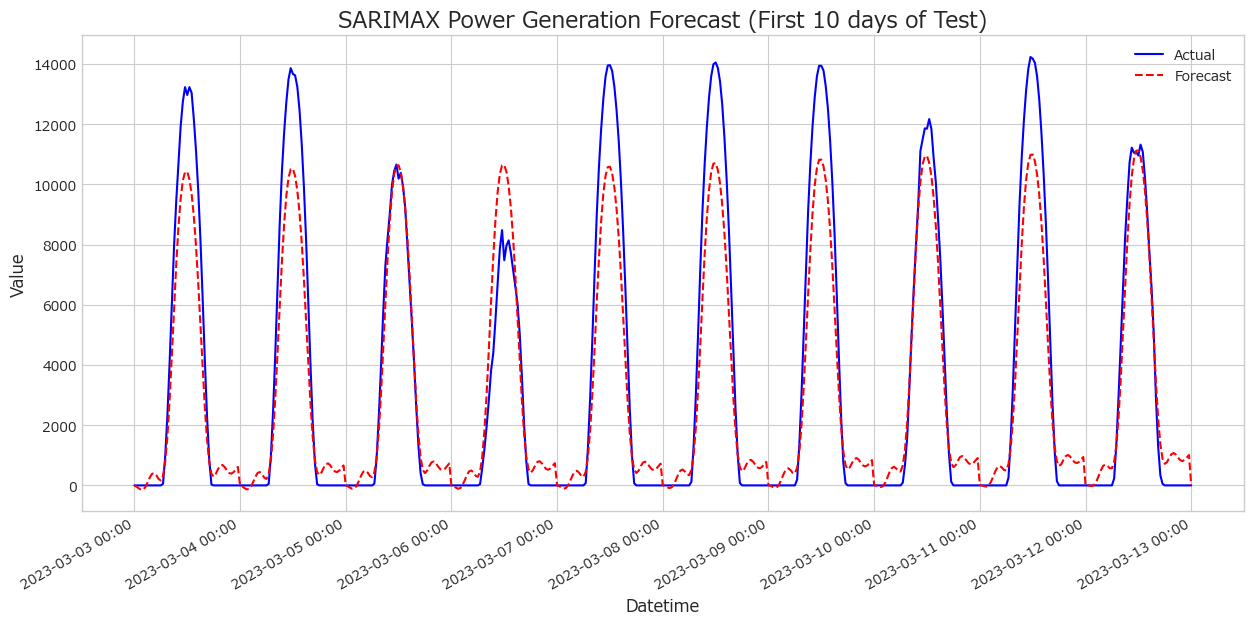

In [11]:
# 発電量の予測
print("SARIMAX (solar_gen_mw): 予測を開始...")
sarima_gen_preds_df, sarima_gen_models, _ = sliding_window_forecast(
    data=df,
    y_col='solar_gen_mw',
    train_length=TRAIN_LENGTH,
    test_length=TEST_LENGTH,
    slide_count=SLIDE_COUNT,
    stride=STRIDE,
    model_func=sarimax_exog_model_wrapper,
    model_params={'order': gen_order, 'all_exog': fourier_terms_gen_full}
    )
print("完了。")

# 評価
y_train_gen = df['solar_gen_mw'].iloc[:TRAIN_LENGTH]
arima_gen_metrics = evaluate_forecast(sarima_gen_preds_df['true'], sarima_gen_preds_df['pred'], y_train_gen.values, m=48)
arima_summary_gen = pd.Series(arima_gen_metrics, name='generation')
print("--- SARIMAX (solar_gen_mw) 評価結果 (30日間) ---")
print(arima_summary_gen)

# 結果の視覚化
plot_forecast_vs_actual(
    results_df=sarima_gen_preds_df,
    title='SARIMAX Power Generation Forecast (First 10 days of Test)',
    days_to_show=10
)

SARIMAX (e_demand_mw): 予測を開始...


Sliding Window:   0%|          | 0/30 [00:00<?, ?it/s]

完了。
--- SARIMAX (e_demand_mw) 評価結果 (30日間) ---
MAE     1712.421866
RMSE    2372.984690
MASE       0.542261
Name: consumption, dtype: float64


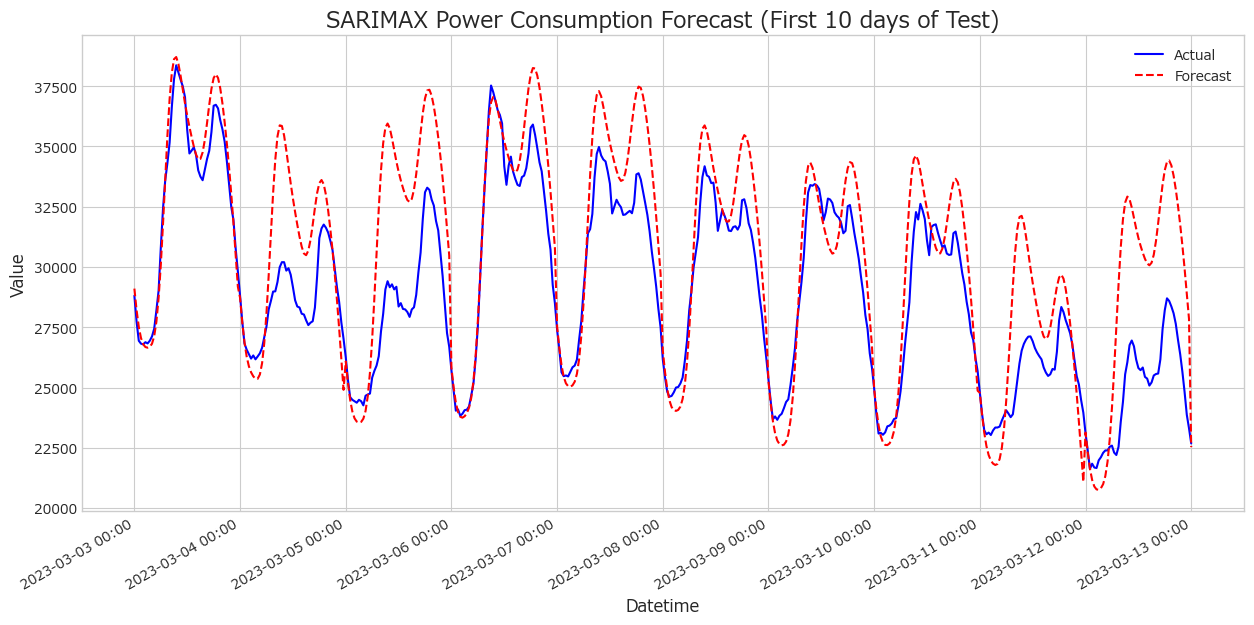

In [12]:
# 消費量の予測
print("SARIMAX (e_demand_mw): 予測を開始...")
sarima_con_preds_df, sarima_con_models, _ = sliding_window_forecast(
    data=df,
    y_col='e_demand_mw',
    train_length=TRAIN_LENGTH,
    test_length=TEST_LENGTH,
    slide_count=SLIDE_COUNT,
    stride=STRIDE,
    model_func=sarimax_exog_model_wrapper,
    model_params={'order': con_order, 'all_exog': fourier_terms_con_full}
    )
print("完了。")

# 評価
y_train_con = df['e_demand_mw'].iloc[:TRAIN_LENGTH]
arima_con_metrics = evaluate_forecast(sarima_con_preds_df['true'], sarima_con_preds_df['pred'], y_train_con.values, m=336)
arima_summary_con = pd.Series(arima_con_metrics, name='consumption')
print("--- SARIMAX (e_demand_mw) 評価結果 (30日間) ---")
print(arima_summary_con)

# 結果の視覚化
plot_forecast_vs_actual(
    results_df=sarima_con_preds_df,
    title='SARIMAX Power Consumption Forecast (First 10 days of Test)',
    days_to_show=10
)

In [13]:
# 結果の保存
# pred_df には 'true', 'pred' カラムと datetime index がある前提

# solar_gen_mw
sarima_gen_preds_df.to_pickle('../results/preds/solar_SARIMAX.pkl')
print("Saved: ")

# e_demand_mw
sarima_con_preds_df.to_pickle('../results/preds/demand_SARIMAX.pkl')
print("Saved: ")

Saved: 
Saved: 


#### 4-3-3. 考察と残差診断

#### 結果の解釈と次工程への示唆（発電量）
- Holt-Wintersモデルと比較して、SARIMAX（フーリエ項使用）の**MASE**は大きな改善が見られず、依然として季節ナイーブ予測を下回る性能となった。
- この結果から、発電量の非線形な日変動やランダムな天候要因といった**ARIMAモデルでは捉えきれない構造**が残差に多く含まれていることが示唆される。特に太陽光発電は日射量に依存するため、1年周期の季節性や、日没後の発電量をゼロとして扱うなどの外的な工夫を施す必要がある。

#### 結果の解釈と次工程への示唆（消費量）
SARIMAX（フーリエ項使用）は、Holt-Wintersモデルと同等、あるいはそれをわずかに上回る高い精度を達成している。**MASEが1.0を大きく下回る**ことは、複雑な二重季節性（日・週周期）を持つ消費量データに対して、フーリエ項とARIMA構造を組み合わせたモデルが非常に有効であることを裏付けている。ベースラインモデルとして、消費量予測においては十分な性能を有していると評価できる。


**残差診断**

- SARIMAXモデルの妥当性を確認するため、最後のスライディングウィンドウで学習されたモデルの残差について診断を実施する。

--- SARIMAX (solar_gen_mw) Residual Diagnostics ---


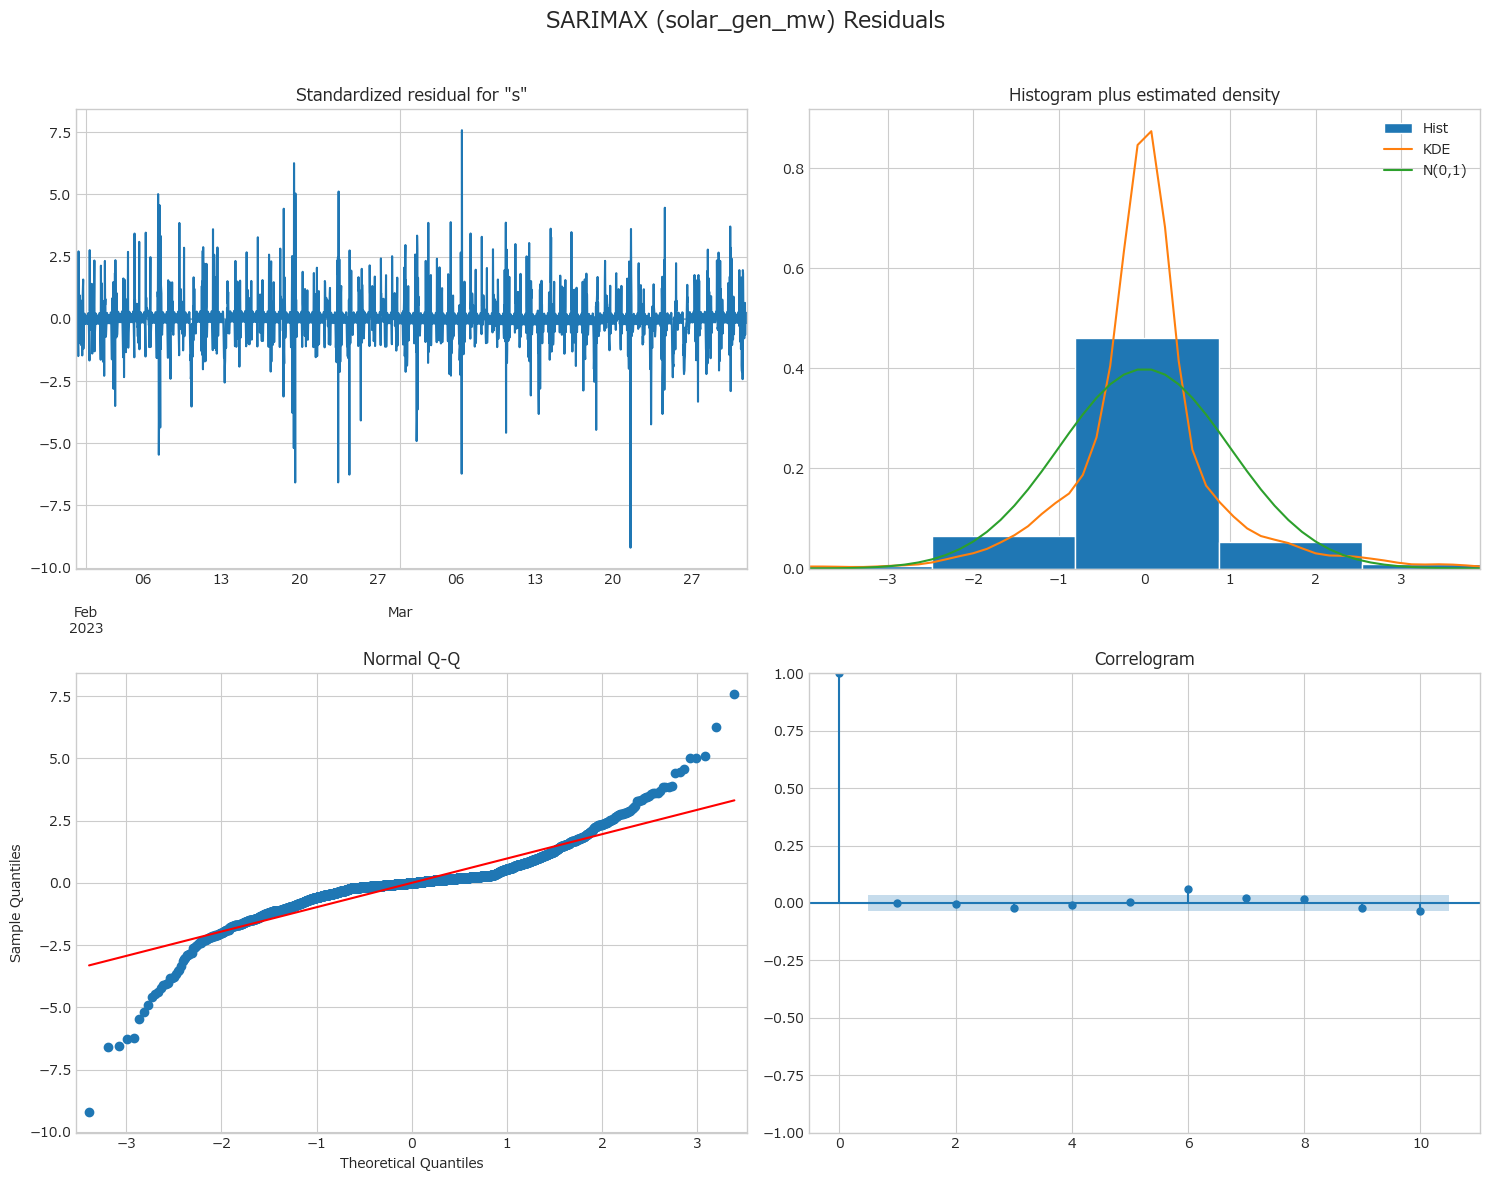

In [14]:
# 発電量モデルの残差診断
print("--- SARIMAX (solar_gen_mw) Residual Diagnostics ---")
if 'sarima_gen_models' in locals() and sarima_gen_models:
    last_gen_model = sarima_gen_models[-1]
    if last_gen_model:
        fig = last_gen_model.plot_diagnostics(figsize=(15, 12))
        fig.suptitle("SARIMAX (solar_gen_mw) Residuals", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
    else:
        print("発電量モデルが見つかりませんでした。")
else:
    print("発電量モデルのリストが空です。")

**診断結果**:
- Q-Qプロットにおいて両端で正規分布からの大きなズレが確認され、残差の正規性が確保されていない。また、残差の時系列プロットや自己相関関数（ACF）にも、モデルが説明できていない構造（特に非線形性や外的な急変）が残っている可能性が示唆される。


--- SARIMAX (e_demand_mw) Residual Diagnostics ---


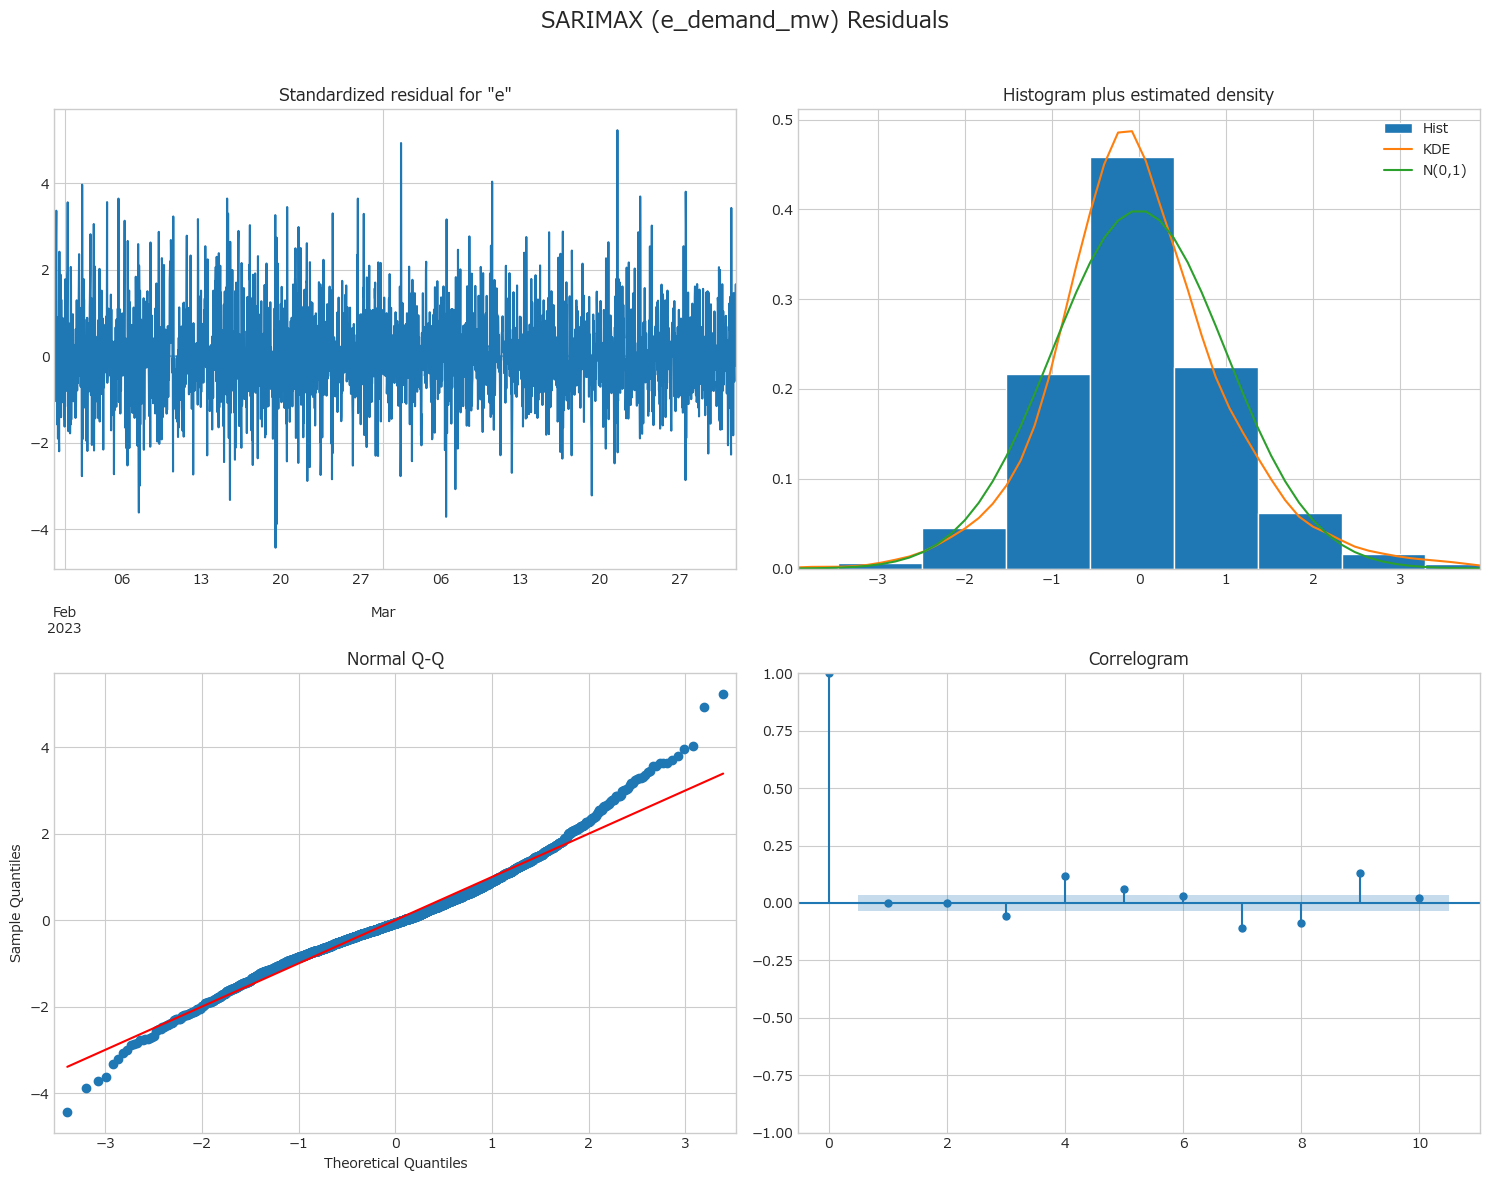

In [15]:
# 消費量モデルの残差診断
print("\n--- SARIMAX (e_demand_mw) Residual Diagnostics ---")
if 'sarima_con_models' in locals() and sarima_con_models:
    last_con_model = sarima_con_models[-1]
    if last_con_model:
        fig = last_con_model.plot_diagnostics(figsize=(15, 12))
        fig.suptitle("SARIMAX (e_demand_mw) Residuals", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
    else:
        print("消費量モデルが見つかりませんでした。")
else:
    print("消費量モデルのリストが空です。")

**診断結果**:
- 残差は概ねホワイトノイズに近く、Q-Qプロットも中央部では正規性に近似している。ただし、ACFのラグ数が多い部分で有意な相関がわずかに残っている可能性があり、さらなるモデル改善の余地がある。

**残差の自己相関の検定**
- 視覚的な診断に加え、**リュング・ボックス（Ljung-Box）検定**により、残差に自己相関が残存していないかを統計的に評価する。帰無仮説は「残差に系列相関がない」であり、p値が有意水準（例: 0.05）より大きい場合にモデルが適切と判断できる。

In [16]:
# Ljung-Box検定による残差の自己相関の確認
from statsmodels.stats.diagnostic import acorr_ljungbox

# 最後のウィンドウで学習されたモデルを取得
last_gen_model = sarima_gen_models[-1]
last_con_model = sarima_con_models[-1]

# 発電量モデルの残差を取得
resid_gen = last_gen_model.resid
# 消費量モデルの残差を取得
resid_cons = last_con_model.resid

# lagsの数を設定（例として48を設定）
lags = 48

# Ljung-Box検定を実行
lb_test_gen = acorr_ljungbox(resid_gen, lags=[lags], return_df=True)
print("--- 発電量モデル残差のLjung-Box検定結果 ---")
print(lb_test_gen)
print("\n")

lb_test_cons = acorr_ljungbox(resid_cons, lags=[lags], return_df=True)
print("--- 消費量モデル残差のLjung-Box検定結果 ---")
print(lb_test_cons)

--- 発電量モデル残差のLjung-Box検定結果 ---
       lb_stat     lb_pvalue
48  224.435257  1.264168e-24


--- 消費量モデル残差のLjung-Box検定結果 ---
       lb_stat     lb_pvalue
48  146.151646  7.555506e-12


**SARIMAXモデルの総括考察:**
- **発電量予測**: Holt-Winters同様、予測精度は芳しくない。残差診断のLjung-Box検定でもp値が有意水準を下回り、残差に自己相関が残存していることが示された。これは天候など未考慮の外部要因の影響が大きく、モデルがデータ構造を捉えきれていないことを示唆している。
- **消費量予測**: MASEは0.54と良好な結果を示した。残差もホワイトノイズに近く、フーリエ項を伴うSARIMAXが消費量の持つ複雑な季節性を適切にモデル化できていることが確認された。
- **モデル選択の観点**: SARIMAXは高い表現力を持つが、パラメータ探索やフーリエ項の設計に工数を要する。今回のように周期が長いデータに対しては、フーリエ項の活用が効果的であったが、計算時間と工数を要する手法であった。(当初フーリエ項を用いず、季節性周期Sを336や48としてパラメータ計算等で長時間かかっていた。)

### 4-4. 結論：ベースラインモデルの比較と総括

In [17]:
# SARIMAXモデルの評価結果を結合
try:
    arima_summary = pd.concat([arima_summary_gen, arima_summary_con], axis=1)
except NameError:
    print("arima_summary_gen または arima_summary_con が定義されていません。前のセルの実行を確認してください。")
    # ダミーのデータフレームを作成してエラーを防ぐ
    dummy_metrics = {'MAE': np.nan, 'RMSE': np.nan, 'MASE': np.nan}
    arima_summary_gen = pd.Series(dummy_metrics, name='generation')
    arima_summary_con = pd.Series(dummy_metrics, name='consumption')
    arima_summary = pd.concat([arima_summary_gen, arima_summary_con], axis=1)

# Holt-WintersとSARIMAXの評価指標を結合して比較
try:
    comparison_df = pd.concat([hw_summary, arima_summary], axis=1, keys=['Holt-Winters', 'SARIMAX'])
    print("--- モデル精度比較 (MAE, RMSE, MASEの平均値) ---")
    print(comparison_df)
except NameError:
    print("hw_summary または arima_summary が定義されていません。前のセルの実行を確認してください。")

--- モデル精度比較 (MAE, RMSE, MASEの平均値) ---
     Holt-Winters                   SARIMAX             
       generation  consumption   generation  consumption
MAE   1663.867984  1663.890819  1395.820883  1712.421866
RMSE  2740.709025  2212.888753  2278.535709  2372.984690
MASE     2.261408     0.526893     1.897098     0.542261


**ベースラインモデルの結論**

#### 精度比較サマリー
各モデルの評価指標は以下の通りである。

| 目的変数 | モデル | MAE | RMSE | MASE |
| :--- | :--- | :--- | :--- | :--- |
| **発電量** | Holt-Winters | 1663.87 | 2740.71 | 2.261 |
| | SARIMAX | 1395.82 | 2278.54 | 1.897 |
| **消費量** | Holt-Winters | 1663.89 |  2212.89 | 0.527 |
| | SARIMAX | 1712.42 | 2372.98 | 0.542 |


#### 総括
- **消費量予測**では、Holt-Winters法、SARIMAXモデル共にMASEが1を大きく下回り、有効なベースラインであることが確認された。
- **発電量予測**では、両モデルとも精度が低く、ベースラインとして不十分な結果となった。これは、天候など不規則な外部要因に強く依存するため、過去の時系列パターンのみでは変動を捉えきれないことを示唆している。
- **モデル選択に関する知見**:
    - **Holt-Winters法**: 実装が容易で計算も高速。強い季節性を持つデータに対し、迅速にベースラインを構築する上で有用である。
    - **SARIMAX法**: フーリエ項との組み合わせで複雑な周期性に対応可能だが、工数と計算時間を要する。周期が長いデータには不向きな側面もあった。

**今後の展望:**
発電量予測の精度向上が課題である。次工程では、天候データ等の外部特徴量を追加し、LightGBMなどの機械学習モデルの導入を検討する。